# Waves
##### A GWDST notebook for managing the huge dataset that is all BTAU parameterized GW outputs for GWDST WACCM run. Check ../scripts/waves.py for most recent analysis!

### Input and data

In [1]:
%matplotlib inline

from glob import glob
import numpy as np
from scipy.stats import lognorm
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import seaborn as sns
#import cartopy.crs as ccrs

from dask.distributed import Client

sns.set(context='talk')#, style='ticks')

In [2]:
client = Client()#(processes=False)
client

Client Scheduler: tcp://127.0.0.1:40783 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


### Input and dataset creation/manipulation

In [3]:
ds = xr.open_mfdataset(sorted(glob('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-0[6,7]*')), decode_times=False)

ds = ds.sel(lat=slice(-30,30))

#Separate out GW flux vars and convert Pa -> mPa
gwx = xr.Dataset({var: ds[var] for var in ds.data_vars if 'BTAUX' in var}) * 1000
gwy = xr.Dataset({var: ds[var] for var in ds.data_vars if 'BTAUY' in var}) * 1000

Now I will read in and find the magnitude of tau from the individual directions and save it separately to have and to save time!

```
tau = xr.Dataset({str(i): xu.sqrt(xu.square(gwx[x]) + xu.square(gwy[y])) for (i, (x,y)) in enumerate(zip(gwx.data_vars, gwy.data_vars))})

tau = xr.concat([tau[i] for i in tau.data_vars], pd.Index(np.arange(1,65), name='wave'))


tau.to_dataset().to_netcdf('/glade/scratch/mcamron/output/gwdst/tau_magnitude.nc')
```

Let's make sure to read that in now instead of running these calculations. Now, I want to find and compare distributions of the wave fluxes at certain near-tropopause altitudes.

In [4]:
tau = xr.open_dataset('/glade/scratch/mcamron/output/gwdst/tau_magnitude.nc', chunks={'lev': 1, 'time': 24})
tau = tau.sel(lev=slice(50, 130))
tau

<xarray.Dataset>
Dimensions:  (lat: 42, lev: 6, lon: 288, time: 1464, wave: 64)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lev      (lev) float64 51.68 61.52 73.75 87.82 103.3 121.5
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 -13.66 ...
  * time     (time) datetime64[ns] 2002-06-01 2002-06-01T00:59:59 ...
  * wave     (wave) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    0        (wave, time, lev, lat, lon) float32 dask.array<shape=(64, 1464, 6, 42, 288), chunksize=(64, 24, 1, 42, 288)>

In [5]:
tau['wave'] = pd.Index(np.append(np.arange(-2.5, -82.5, -2.5), np.arange(2.5, 82.5, 2.5)))
tau['wave']

<xarray.DataArray 'wave' (wave: 64)>
array([ -2.5,  -5. ,  -7.5, -10. , -12.5, -15. , -17.5, -20. , -22.5, -25. ,
       -27.5, -30. , -32.5, -35. , -37.5, -40. , -42.5, -45. , -47.5, -50. ,
       -52.5, -55. , -57.5, -60. , -62.5, -65. , -67.5, -70. , -72.5, -75. ,
       -77.5, -80. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
        22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,
        47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,
        72.5,  75. ,  77.5,  80. ])
Coordinates:
  * wave     (wave) float64 -2.5 -5.0 -7.5 -10.0 -12.5 -15.0 -17.5 -20.0 ...

In [6]:
gwx = (xr.concat([gwx[i] for i in gwx.data_vars], pd.Index(np.append(np.arange(-2.5, -82.5, -2.5),
                                                                     np.arange(2.5, 82.5, 2.5)), name='wave'))
       .sel(lev=100, method='nearest'))#.chunk({'wave': 64, 'time': 24, 'lat': 64, 'lon': 288}))
gwy = (xr.concat([gwy[i] for i in gwy.data_vars], pd.Index(np.append(np.arange(-2.5, -82.5, -2.5),
                                                                     np.arange(2.5, 82.5, 2.5)), name='wave'))
       .sel(lev=100, method='nearest'))#.chunk({'wave': 64, 'time': 24, 'lat': 64, 'lon': 288}))

### Distributions and lognormal evaluation

In [4]:
tauplot = tau['0'].sel(lev=60, method='nearest')
m = tauplot.where(tauplot > 10**-4).mean(skipna=True).values
v = tauplot.where(tauplot > 10**-4).var(skipna=True).values
mu = xu.log(m / xu.sqrt(1 + v/m**2))
s = xu.sqrt(xu.log(1 + v/m**2))
scale = xu.exp(mu)

x = np.arange(0, 201, 1)

print(m, v, mu, s, scale)

0.2114044725894928 1.3585875034332275 -3.27737007408 1.85654950126 0.0377273465773


In [5]:
m2 = tauplot.where(tauplot > 10**-4).mean(skipna=True).values
v2 = tauplot.where(tauplot > 10**-4).var(skipna=True).values
mu2 = xu.log(m2 / xu.sqrt(1 + v2/m2**2))
s2 = xu.sqrt(xu.log(1 + v2/m2**2))
scale2 = xu.exp(mu2)

m3 = tauplot.where(tauplot > 10**-2).mean(skipna=True).values
v3 = tauplot.where(tauplot > 10**-2).var(skipna=True).values
mu3 = xu.log(m3 / xu.sqrt(1 + v3/m3**2))
s3 = xu.sqrt(xu.log(1 + v3/m3**2))
scale3 = xu.exp(mu3)

m4 = tauplot.where(tauplot > 1).mean(skipna=True).values
v4 = tauplot.where(tauplot > 1).var(skipna=True).values
mu4 = xu.log(m4 / xu.sqrt(1 + v4/m4**2))
s4 = xu.sqrt(xu.log(1 + v4/m4**2))
scale4 = xu.exp(mu4)

m5 = tauplot.where(tauplot > 2).mean(skipna=True).values
v5 = tauplot.where(tauplot > 2).var(skipna=True).values
mu5 = xu.log(m5 / xu.sqrt(1 + v5/m5**2))
s5 = xu.sqrt(xu.log(1 + v5/m5**2))
scale5 = xu.exp(mu5)

In [6]:
colors = sns.color_palette('Dark2', 5)
colors = colors.as_hex()

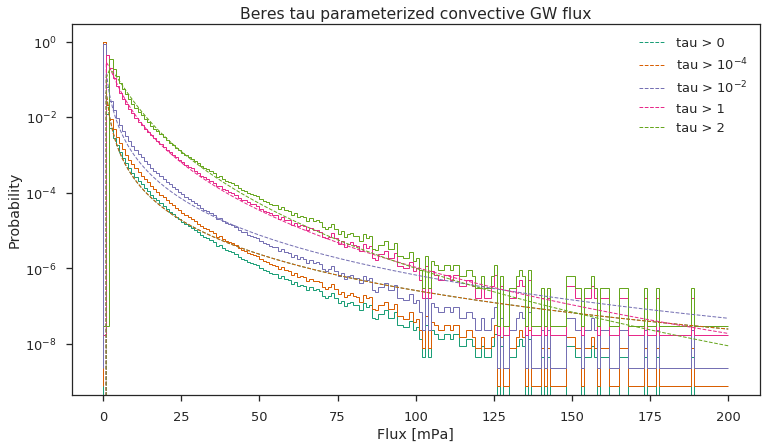

In [7]:
f, ax = plt.subplots(figsize=(11, 6.5))

(tauplot.where(tauplot > 0)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[0]))

(tauplot.where(tauplot > 10**-4)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[1]))

(tauplot.where(tauplot > 10**-2)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[2]))

(tauplot.where(tauplot > 1)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[3]))

(tauplot.where(tauplot > 2)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[4]))

ax.plot(x, lognorm.pdf(x, s, scale=scale), linewidth=1, c=colors[0], ls='dashed', label=('tau > 0'))
ax.plot(x, lognorm.pdf(x, s2, scale=scale2), linewidth=1, c=colors[1], ls='dashed', label=(r'tau > $10^{-4}$'))
ax.plot(x, lognorm.pdf(x, s3, scale=scale3), linewidth=1, c=colors[2], ls='dashed', label=(r'tau > $10^{-2}$'))
ax.plot(x, lognorm.pdf(x, s4, scale=scale4), linewidth=1, c=colors[3], ls='dashed', label=(r'tau > 1'))
ax.plot(x, lognorm.pdf(x, s5, scale=scale5), linewidth=1, c=colors[4], ls='dashed', label=(r'tau > 2'))

ax.legend(loc='upper right')
ax.set_xlabel('Flux [mPa]')
ax.set_ylabel('Probability')
ax.set_title('Beres tau parameterized convective GW flux')

plt.tight_layout()

f.savefig('../figures/waves/dist_flux_LN.png')

Using the above and *Vincent and Hertzog 2014* I will use the orange tau $> 10^{-2}$ distribution cutoff for more comparisons. Above plots at 61.52 hPa.

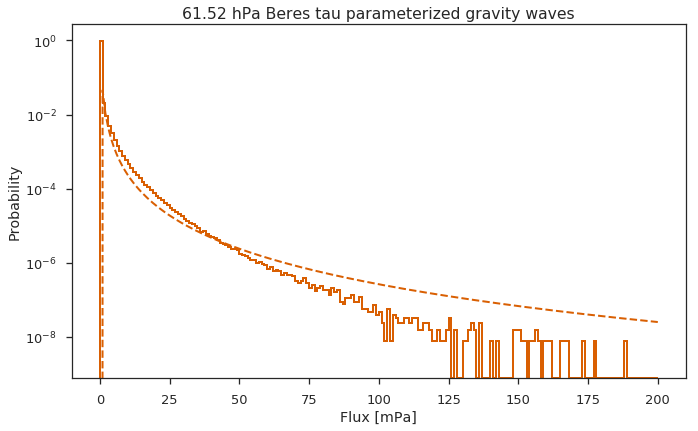

In [13]:
f, ax = plt.subplots(figsize=(11, 6.5))

(tauplot.where(tauplot > 10**-4)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step', linewidth=2, color=colors[1]))

ax.plot(x, lognorm.pdf(x, s2, scale=scale2), linewidth=2, ls='dashed', color=colors[1])

ax.set_xlabel('Flux [mPa]')
ax.set_ylabel('Probability')
ax.set_title('%0.2f hPa Beres tau parameterized gravity waves' % (tauplot.lev))

f.savefig('../figures/waves/dist_flux.png')

### Distributions of phase symmetry

In [7]:
tau_lev = tau['0'].sel(lev=100, method='nearest')
tau_lev = tau_lev.where(tau_lev > 10**(-4))

In [9]:
sym_mean = tau_lev.stack(Z=('lon', 'lat', 'time')).mean(dim='Z', skipna=True).values

/glade/u/home/mcamron/miniconda3/envs/gwdst/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


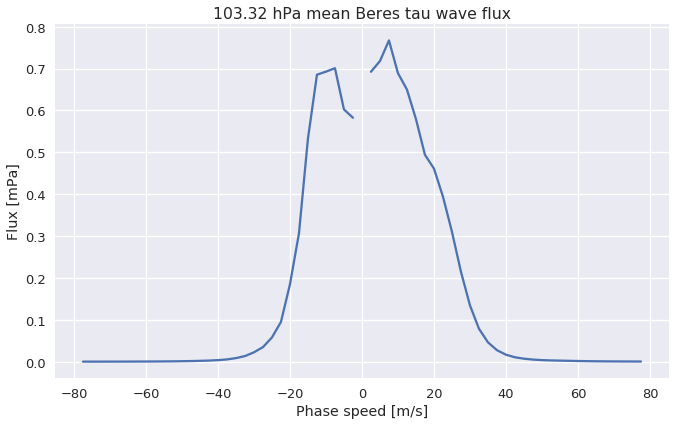

In [ ]:
f, ax = plt.subplots(figsize=(11, 6.5))

ax.plot(tau['wave'], sym_mean)

ax.set_xlabel('Phase speed [m/s]')
ax.set_ylabel('Flux [mPa]')
ax.set_title('%0.2f hPa mean Beres tau wave flux' % tau_lev.lev)

f.savefig('../figures/waves/mean_tau_symmetry.png')

### Phase-flux distribution

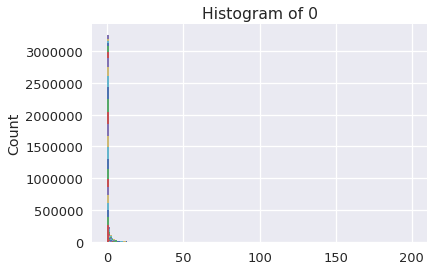

In [8]:
tau_2dhist = np.empty((len(tau_lev['wave']), 200))
for (i, x) in enumerate(tau_lev['wave']):
    n, bins, patches = tau_lev.sel(wave=x).plot.hist(bins=np.arange(0, 201, 1))
    tau_2dhist[i, :] = n

In [9]:
plot_2dhist = tau_2dhist.T
#plot_2dhist[:, 0:31] = plot_2dhist[:, 31:0:-1]

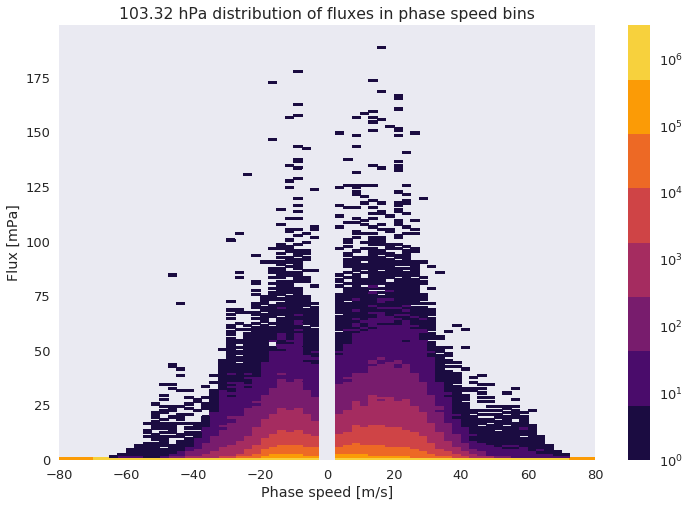

In [10]:
f, ax = plt.subplots(figsize=(12, 8))

p = ax.pcolormesh(tau_lev['wave'], np.arange(0, 200, 1), plot_2dhist, norm=LogNorm(), cmap=ListedColormap(sns.mpl_palette('inferno', n_colors=8)))
plt.colorbar(p)

ax.set_xlabel('Phase speed [m/s]')
ax.set_ylabel('Flux [mPa]')
ax.set_title('%0.2f hPa distribution of fluxes in phase speed bins' % tau_lev.lev)

f.savefig('../figures/waves/dist_2d_flux-c.png')

### Latitudinal breakdown

In [11]:
x_lat_wave_mean = gwx.stack(Z=('lon', 'time')).mean(dim='Z', skipna=True).values

In [12]:
y_lat_wave_mean = gwy.stack(Z=('lon', 'time')).mean(dim='Z', skipna=True).values

In [13]:
yx = np.append(x_lat_wave_mean[31::-1, :], x_lat_wave_mean[32:, :], axis=0)
yy = np.append(y_lat_wave_mean[31::-1, :], y_lat_wave_mean[32:, :], axis=0)

In [31]:
x = gwx.wave.values

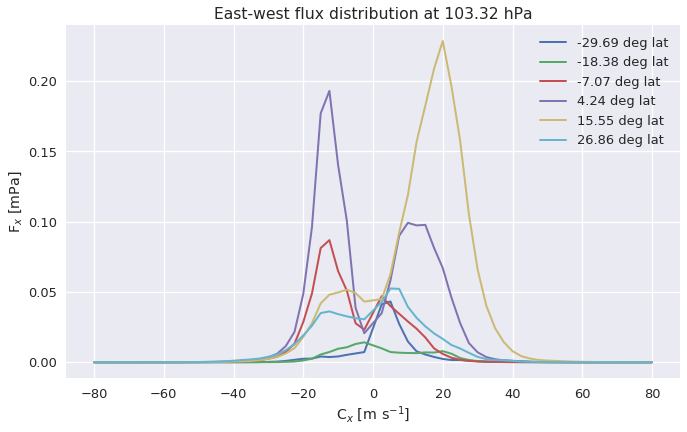

In [32]:
f, ax = plt.subplots(figsize=(11, 6.5))

for i in range(0, 64, 12):
    ax.plot(x, yx[:, i], label=('%0.2f deg lat' % gwx.lat[i].values), linewidth=2)

ax.legend()
ax.set_xlabel(u'C$_x$ [m s$^{-1}$]')
ax.set_ylabel(u'F$_x$ [mPa]')
ax.set_title('East-west flux distribution at %0.2f hPa' % gwx.lev)

f.savefig('../figures/waves/dist_cx.png')

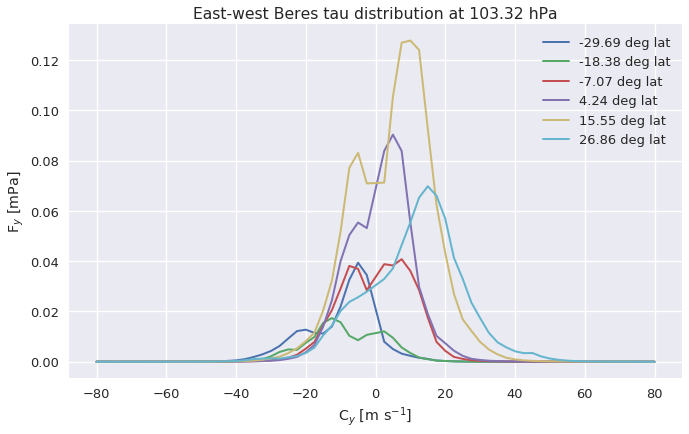

In [33]:
f, ax = plt.subplots(figsize=(11, 6.5))

for i in range(0, 64, 12):
    ax.plot(x, yy[:, i], label=('%0.2f deg lat' % gwx.lat[i].values), linewidth=2)

ax.legend()
ax.set_xlabel(u'C$_y$ [m s$^{-1}$]')
ax.set_ylabel(u'F$_y$ [mPa]')
ax.set_title('East-west Beres tau distribution at %0.2f hPa' % gwx.lev)

f.savefig('../figures/waves/dist_cy.png')

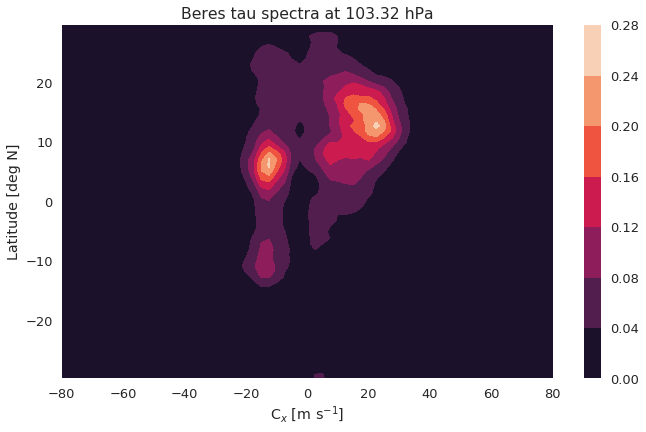

In [34]:
f, ax = plt.subplots(figsize=(11, 6.5))

p = ax.contourf(x, gwx.lat.values, yx.T)
plt.colorbar(p)

ax.set_xlabel(u'C$_x$ [m s$^{-1}$]')
ax.set_ylabel('Latitude [deg N]')
ax.set_title('Beres tau spectra at %0.2f hPa' % gwx.lev)

f.savefig('../figures/waves/spec_cx.png')

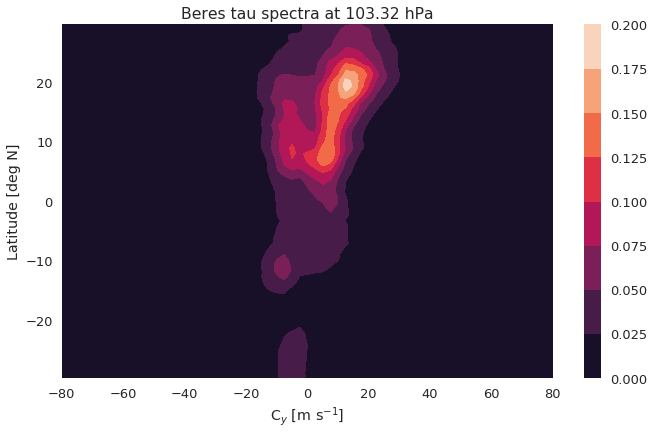

In [35]:
f, ax = plt.subplots(figsize=(11, 6.5))

p = ax.contourf(x, gwy.lat.values, yy.T)
plt.colorbar(p)

ax.set_xlabel(u'C$_y$ [m s$^{-1}$]')
ax.set_ylabel('Latitude [deg N]')
ax.set_title('Beres tau spectra at %0.2f hPa' % gwx.lev)

f.savefig('../figures/waves/spec_cy.png')